In [1]:
#packages
import pandas as pd
import numpy as np
import warnings
import sqlite3

from numpy import asarray
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler, normalize
from sklearn import metrics
from xgboost import XGBRFRegressor

In [2]:
# hide warnings
warnings.filterwarnings('ignore')

In [3]:
def prepare_data():
    df = read_data()
    df = format_columns(df)
    
    df["zipcode"] = pd.to_numeric(df["zipcode"], errors='coerce')
    df["station_area"] = pd.to_numeric(df["station_area"], errors='coerce')
    df["ems_units"] = pd.to_numeric(df["ems_units"], errors='coerce')
    df["supervisor_district"] = pd.to_numeric(df["supervisor_district"], errors='coerce')
    
    #Ignore NaN rows
    df = df[df['minutes'].notna()]
    df = df[df['point_x'].notna()]
    df = df[df['point_y'].notna()]
    df = df[df['zipcode'].notna()]
    df = df[df['station_area'].notna()]
    df = df[df['ems_units'].notna()]
    df = df[df['supervisor_district'].notna()]
    
    return df

In [4]:
def read_data():
    con = sqlite3.connect("fire_data_v4.db")
    cur = con.cursor()

    df = pd.read_sql('SELECT ' \
                     'fi.zipcode, fi.supervisor_district, fi.alarm_dttm, fi.arrival_dttm, fi.box, fi.ems_units, fi.station_area, cfs.case_location ' \
                     'FROM fire_incidents AS fi INNER JOIN calls_for_service AS cfs ON fi.incident_number = cfs.incident_number INNER JOIN nearest_distances AS nd ON fi.incident_number = nd.incident_number',con = con)
    
    return df

In [5]:
def format_columns(df):
    df['alarm_format'] = pd.to_datetime(df['alarm_dttm'])
    df['arrival_format'] = pd.to_datetime(df['arrival_dttm'])
    df['arrival_time'] = (df['arrival_format'] - df['alarm_format'])
    df['minutes'] = (df.arrival_time.dt.seconds) / 60
    df['seconds'] = (df.arrival_time.dt.seconds)
    df['day_of_week'] = df['alarm_format'].dt.dayofweek
    df['dayflag'] = (df.alarm_format.dt.hour > 5) & (df.alarm_format.dt.hour < 18)
    
    point = df['case_location'].str.split(' ', n = 2, expand = True)
    point_x = point[1].str.split('(', n = 1, expand = True)
    point_y = point[2].str.split(')', n = 1, expand = True)
    
    df['point_x'] = point_x[1]
    df['point_y'] = point_y[0]
    
    return df

In [6]:
df = prepare_data()
df.head()

,zipcode,supervisor_district,alarm_dttm,arrival_dttm,box,ems_units,station_area,case_location,alarm_format,arrival_format,arrival_time,minutes,seconds,day_of_week,dayflag,point_x,point_y
0,94110.0,9.0,2008-04-01 18:06:37,2008-04-01 18:15:19,None,0,11.0,POINT (-122.418144723562 37.742224086608),2008-04-01 18:06:37,2008-04-01 18:15:19,0 days 00:08:42,8.700000,522.0,1,False,-122.418144723562,37.742224086608
1,94107.0,10.0,2008-04-01 18:00:52,2008-04-01 18:06:30,None,0,37.0,POINT (-122.395114989 37.756639987211),2008-04-01 18:00:52,2008-04-01 18:06:30,0 days 00:05:38,5.633333,338.0,1,False,-122.395114989,37.756639987211
12,94102.0,5.0,2008-04-01 19:03:52,2008-04-01 19:08:39,None,0,36.0,POINT (-122.427077545588 37.776304759752),2008-04-01 19:03:52,2008-04-01 19:08:39,0 days 00:04:47,4.783333,287.0,1,False,-122.427077545588,37.776304759752
17,94109.0,3.0,2008-04-01 20:09:55,2008-04-01 20:12:29,None,0,1.0,POINT (-122.405221175679 37.788693991132),2008-04-01 20:09:55,2008-04-01 20:12:29,0 days 00:02:34,2.566667,154.0,1,False,-122.405221175679,37.788693991132
18,94109.0,3.0,2008-04-01 20:09:55,2008-04-01 20:12:29,None,0,1.0,POINT (-122.405221175679 37.788693991132),2008-04-01 20:09:55,2008-04-01 20:12:29,0 days 00:02:34,2.566667,154.0,1,False,-122.405221175679,37.788693991132


In [7]:
class ModelData:
    x = None
    y = None
    x_train = None
    x_test = None
    y_train = None
    y_test = None
    scaled_x_train = None
    scaled_x_test = None

    model = None
    target_to_predict = None
    predictors = None
    XGB = None
    gscv_XGB = None

In [8]:
def configure_sets(md):
    md.predictors = ['zipcode', 'day_of_week','station_area', 'ems_units', 'supervisor_district', 'point_x', 'point_y']
    md.target_to_predict = 'minutes'
    
    md.x = df[md.predictors].values
    md.y = df[md.target_to_predict].values

    #Split the data into training and testing set
    md.x_train, md.x_test, md.y_train, md.y_test = train_test_split(md.x, md.y, test_size = 0.8, random_state = 614)

In [9]:
def data_normalization(md):
    scaler = StandardScaler()
    md.scaled_x_train = scaler.fit_transform(md.x_train)
    md.scaled_x_test = scaler.transform(md.x_test)
    
    print(md.scaled_x_train)
    print("================")
    print(md.scaled_x_test)

In [10]:
def create_model(md):
    #data_normalization(md)
    
    md.model = XGBRFRegressor(n_estimators = 1000, subsample = 0.9, colsample_bynode = 0.2)

    #Printing all the parameters of XGBoost
    print(md.model)

In [22]:
def tune_hyper_parameters(md):
    param_grid = { 
        'n_estimators': [100, 1000, 2000]
    }

    md.gscv_XGB = GridSearchCV(estimator = md.model, param_grid = param_grid)
    md.gscv_XGB.fit(md.scaled_x_train, md.y_train)
    
    print(md.gscv_XGB.best_params_)
    
    #Run result, todo - test with more parameters
    #{'n_estimators': 1000}

In [12]:
def fit_data(md):
    #Creating the model on Training Data
    md.XGB = md.model.fit(md.scaled_x_train, md.y_train)
    
    prediction = md.XGB.predict(md.x_test)

    #Measuring Goodness of fit in Training data
    print('R2 Value:', metrics.r2_score(md.y_train, md.XGB.predict(md.x_train)))

    #Measuring accuracy on Testing Data
    print('Accuracy', 100 - (np.mean(np.abs((md.y_test - prediction) / md.y_test)) * 100))

    #Plotting the feature importance for Top 10 most important columns 
    %matplotlib inline
    feature_importances = pd.Series(md.XGB.feature_importances_, index = md.predictors)
    feature_importances.nlargest(10).plot(kind = 'barh')

In [13]:
def predict_using_training_set(md):
    prediction = md.XGB.predict(md.x_test)
    
    training_set_predictions = pd.DataFrame(data = md.x_test, columns = md.predictors)
    training_set_predictions[md.target_to_predict] = md.y_test
    training_set_predictions[('Predicted' + md.target_to_predict)] = prediction
    training_set_predictions.head()
    
    print(training_set_predictions.head())

In [17]:
model_data = ModelData()

configure_sets(model_data)
data_normalization(model_data)

[[-0.5499791   1.00179101  0.49718553 ... -1.4216215  -0.00840004
   1.3625251 ]
 [-0.86340315 -1.51485429  1.00245994 ... -0.05640549  0.9434725
   0.80228331]
 [-0.31491107 -1.01152523  1.57991641 ...  1.30881051  0.17679708
  -1.91776784]
 ...
 [-0.47162309 -1.51485429 -1.01863769 ...  0.96750651  0.13559643
  -0.18052425]
 [ 1.40892121  1.50512007  1.50773435 ...  1.30881051  0.91796157
  -1.26285749]
 [-0.5499791  -0.50819617  0.49718553 ... -1.4216215  -0.03244648
   1.39350139]]
[[-0.07984303  1.50512007  0.71373171 ... -1.7629255  -1.34977814
   0.4667058 ]
 [-0.94175917  1.00179101  1.00245994 ... -0.05640549  0.99821059
   0.83178304]
 [-0.15819904  0.49846195  1.50773435 ...  1.30881051  0.88798013
  -1.20880776]
 ...
 [ 0.62536109  0.49846195 -0.29681711 ...  1.30881051  1.40860902
  -1.35520224]
 [-0.62833512  1.50512007 -0.58554534 ... -1.08031749  0.61421046
   0.81310189]
 [ 0.076869   -0.00486711 -1.16300181 ... -0.39770949 -0.44392123
   0.3995052 ]]


In [18]:
create_model(model_data)
#tune_hyper_parameters(model_data)

XGBRFRegressor(base_score=None, booster=None, colsample_bylevel=None,
               colsample_bynode=0.2, colsample_bytree=None,
               enable_categorical=False, gamma=None, gpu_id=None,
               importance_type=None, interaction_constraints=None,
               max_delta_step=None, max_depth=None, min_child_weight=None,
               missing=nan, monotone_constraints=None, n_estimators=1000,
               n_jobs=None, num_parallel_tree=None,
               objective='reg:squarederror', predictor=None, random_state=None,
               reg_alpha=None, scale_pos_weight=None, subsample=0.9,
               tree_method=None, validate_parameters=None, verbosity=None)
{'n_estimators': 1000}


R2 Value: -0.09581801868218731
Accuracy -inf


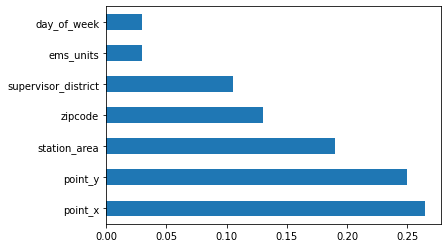

In [19]:
fit_data(model_data)

In [20]:
predict_using_training_set(model_data)

   zipcode day_of_week station_area ems_units supervisor_district  \
0  94115.0           6         31.0         1                 1.0   
1  94104.0           5         35.0         0                 6.0   
2  94114.0           4         42.0         0                10.0   
3  94111.0           2         28.0         0                 3.0   
4  94110.0           3         11.0         0                 8.0   

             point_x          point_y   minutes  Predictedminutes  
0  -122.458731621534  37.779333157982  6.366667          6.719902  
1  -122.394762431104  37.789619378253  6.283333          6.780571  
2  -122.397765577236  37.732124787496  4.816667          6.780571  
3  -122.414598058157  37.806394812885  4.916667          6.780571  
4  -122.425532892336  37.743823671783  2.100000          6.780571  
